# Koc University
## DASC 591 - Non-Thesis Master Term Project

## Time Series Forecasting on Stock Market

### Instructor: Barış Akgün
### Student: Doğuhan Çiftçi

This project is designed for the DASC 591 course. Student will develop a project which will combine modern portfolio theory with the time-series forecasting for stock market. Project should be based on real stock market data which should consists of companies from several sectors such as technology, refinery and automotive. Project will perform time-series forecasting by using the most recent 3 months data to predict the next week’s stock value. Based on the predictions, project will simulate buys and sells according to the modern portfolio theory. In the end, student will analyze the project performance based on the Sharpe ratio.

In [6]:
%matplotlib inline
import ffn
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import matplotlib.pyplot as plt
import pandas as pd
import pmdarima as pmd
import pandas_market_calendars as mcal

In [ ]:
'''
### If imports get error:
##### 1. Uncomment this block
##### 2. Run for once
!pip install ffn
!pip install PyPortfolioOpt
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install pmdarima
!pip install pandas_market_calendars
'''

## Define Static Values

***history***: Historical data that will be used to train our model

***historical_data_start_date***: Start date of the historical data

***historical_data_start_date***: End date of the historical data

<br>

***experimental***: Experimental data that will be experimented on (simulation will not use the these before the invesment)

***experimental_data_start_date***: Start date of the experimental data

***experimental_data_end_date***: End date of the experimental data

<br>

***initial_balance***: The initial balance

***default_lag_time***: Lag time during the trades. Simulation will trade once in lag_time days

<br>

***stocks***: Selected stocks from S&P 500

In [7]:
history = None
historical_data_start_date = '2021-01-01'
historical_data_end_date = '2021-09-30'

experimental = None
experimental_data_start_date = '2021-10-01'
experimental_data_end_date = '2021-12-31'

initial_balance = 100000
default_lag_time = 1

stocks = [
    'AZO',  # AutoZone
    'BAC',  # Bank of America Corporation
    'DPZ',  # Domino's Pizza, Inc.
    'GOOGL',  # Alphabet Inc.
    'MSFT',  # Microsoft Corporation
    'TGT',  # Target Corporation
]


## Data Collection

Collect the historial stock prices for ***history*** and ***experimental***

Stock prices are collected via ***ffn*** library. Once a data is retrieved, it is saved to a file and repetitive requests to the same dataset is returned from the saved file.

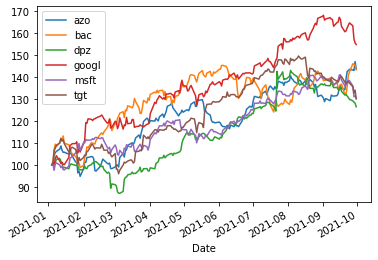

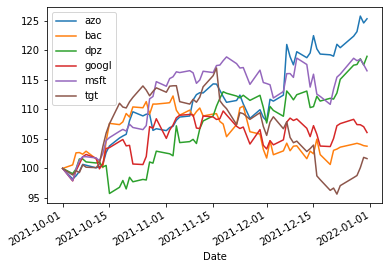

In [8]:
def get_data(stocks, start, end, file):
    '''
    Retrieve the stock value.
    On the first time of asking: retrieve from the internet. Save to file
    Other requests are returned from the file
    '''
    filename = file + '_' + start + '_' + end + '.csv'
    try:
        data = pd.read_csv(filename, index_col=0)
        data.index = pd.to_datetime(data.index)
        return data
    except FileNotFoundError:
        data = ffn.get(stocks, start=start, end=end)
        data.to_csv(filename)
        return data

history = get_data(','.join(stocks), historical_data_start_date, historical_data_end_date, 'history')
fig1 = history.rebase().plot()

experimental = get_data(','.join(stocks), experimental_data_start_date, experimental_data_end_date, 'experimental')
fig2 = experimental.rebase().plot()

## Modern Portfolio Theory

For implementation of the Modern Portfolio Theory, ***PyPortfolioOpt*** library is used.

PyPortfolioOpt library includes classical Efficient Frontier techniques and Black-Litterman allocation methods.

***calculate_weights*** function calculates the expected returns and sample covariance for the given dataset. It performs ***EfficientFrontier*** method to obtain the weights that yields in maximum ***Sharpe Ratio***. 


***invest*** function calculates how many stock shares to buy from each stock according to the weights. It performs ***DiscreteAllocation*** method for calculating the allocation. This function returns the allocation dictionary and leftover balance.

In [9]:
def calculate_weights(data, verbose=False):
    '''
    Given data, this function calculates:
        mean historical return as the expected return
        sample covariance as the risk model
    Then, EfficientFrontier method is used to create the portfolio that yields to maximum Sharpe ratio
    Portfolio performance is printed and weights are returned
    '''
    # Calculate expected returns and sample covariance
    mu = expected_returns.mean_historical_return(data)
    S = risk_models.sample_cov(data)
    
    # Optimize for maximal Sharpe ratio
    ef = EfficientFrontier(mu, S)
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    if verbose:
        print(ef.portfolio_performance(verbose=True))
    return cleaned_weights

example_weights = calculate_weights(history, True)
print('\nWeights:\n', example_weights)

Expected annual return: 65.6%
Annual volatility: 15.0%
Sharpe Ratio: 4.24
(0.6560549410998375, 0.15014515884013774, 4.236266730231753)

Weights:
 OrderedDict([('azo', 0.26368), ('bac', 0.20209), ('dpz', 0.15366), ('googl', 0.38057), ('msft', 0.0), ('tgt', 0.0)])


In [10]:
def invest(prices, weights, balance):
    '''
    This functions allocates the balance according to weights.
    DiscreteAllocation method is used to calculate how many shares to buy from each stock
    Balance is updated with the leftover
    Final balance and allocation dictionary are returned
    '''
    da = DiscreteAllocation(weights, prices, total_portfolio_value=balance)
    allocation, leftover = da.greedy_portfolio()
    return allocation, leftover

example_balance = 100000
print(f'Initial Balance: {example_balance:.2f}$')
latest_prices = get_latest_prices(history)
example_allocation, example_balance = invest(latest_prices, example_weights, example_balance)
print('After investment:')
print("\tAllocation:", example_allocation)
print(f'\tFinal Balance (leftover): {example_balance:.2f}$')


Initial Balance: 100000.00$
After investment:
	Allocation: {'googl': 14, 'azo': 15, 'bac': 478, 'dpz': 32}
	Final Balance (leftover): 1670.95$


## Time Series Forecasting

A famous and widely used forecasting method for time-series forecasting is the **AutoRegressive Integrated Moving Average (ARIMA)** model. 

ARIMA models are capable of capturing a suite of different standard temporal structures in time-series data.

**AR: < Auto Regressive >** means that the model uses the dependent relationship between an observation and some predefined number of lagged observations (also known as “time lag” or “lag”).

**I: < Integrated >** means that the model employs differencing of raw observations (e.g. it subtracts an observation from an observation at the previous time step) in order to make the time-series stationary.

**MA: < Moving Average >** means that the model exploits the relationship between the residual error and the observations.


### Parameter Tuning

***pmdarima*** library provides auto_arima method which is the equivalent of R's auto.arima functionality
This library tries different combinations of ***p***, ***d*** and ***q*** parameters, to obtain the perfect time-series forecaster for the giving data

In [11]:
def get_arima_model(data,
                    start_p=0, max_p=2,
                    start_d=0, max_d=2,
                    start_q=0, max_q=2,
                    trace=False
                    ):
    """
    This function trains the ARIMA model for the given data
    It performs parameter tuning withing the range of start_x and max_x
    Return the trained/tuned model
    """
    return pmd.auto_arima(data,
                          start_p=start_p,  # initial guess for AR(p)
                          start_d=start_d,  # initial guess for I(d)
                          start_q=start_q,  # initial guess for MA(q)
                          max_p=max_p,  # max guess for AR(p)
                          max_d=max_d,  # max guess for I(d)
                          max_q=max_q,  # max guess for MA(q)
                          m=7,  # seasonal order
                          start_P=0,  # initial guess for seasonal AR(P)
                          start_D=0,  # initial guess for seasonal I(D)
                          start_Q=0,  # initial guess for seasonal MA(Q)
                          trend='c',
                          information_criterion='aic',
                          trace=trace,
                          error_action='ignore'
                          )


example_model = get_arima_model(history[history.columns[0]], trace=True)

print(f'\nForecasted next value:\t{example_model.predict(10)[1]:.2f}')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1643.631, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1646.934, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1646.955, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1643.631, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=1645.457, Time=0.10 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=1645.473, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=1646.586, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1645.066, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1645.068, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=1646.559, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 1.252 seconds

Forecasted next value:	1703.53


## Experimentation

In the experimentation part, Modern Portfolio Theory is empowered the Time Series Forecasting.

***experiment*** function simulates a trading with the real stock prices. See below for the explanation of a sample run:

experiment(training_data=history, real_data=experimental, balance=100000, lag_time_param=3, verbose=True)

history dataset contains stock prices between 2021-01-01 and 2021-09-30
experimental dataset contains stock prices between 2021-10-01 and 2021-12-31

The initial balance 100.000$ and lag time is 3.

Starting from the 2021-09-30 (last day of history dataset)
- Time Series Forecasting model is trained for each stock
- Each model forecasts 3 future stock prices
- Stock prices for 2021-10-01, 2021-10-04 and 2021-10-05 are forecasted
- Note that market was closed on 2021-10-02 and 2021-10-03
- history dataset is updated the new forecasted prices
- history dataset now contains stock prices between 2021-01-01 and 2021-10-05
- Modern Portfolio Theory is applied for the history dataset
- The weights that maximizes the Sharpe Ratio is calculated.
- 100.000$ is distributed among stocks according to the weights
- The weights and allocations are as follows:
| Stock | Price on 2021-09-30 | Weight | Allocation |
| :---: | :---: | :---: | :---: |
| azo | 1697.98 | 0.26398 | 15 |
| bac | 42.24 | 0.20218 | 478 |
| dpz | 476.12 | 0.15333 | 32 |
| googl | 2673.52 | 0.38051 | 14 |
| msft | 281.40 | 0.0 | 0 |
| tgt | 227.99 | 0.0 | 0 |

- After stocks are invested, the iteration assumes that it holds the stocks for 3 days
- For last 3 days' real stock prices, experimental dataset is used
- Stocks are cashed out according to the real stock prices on 2021-10-05
- Balance is updated accordingly
- Forecasted prices on history dataset are replaced with the real stock prices
- First 3 days are removed from the experimental dataset.
- History dataset now contains all real stock prices between 2021-01-01 and 2021-10-05
- Experimental dataset now contains real stock prices between 2021-10-06 and 2021-12-31
- Statistics are saved to the df_log DataFrame
- Iteration continues

In [12]:
def experiment(training_data, real_data, balance, lag_time_param, verbose=False):
    """
    This function simulates the trading.
    Starting from the last of the training_data:
        Time series model is trained on the training data to forecast the future prices
        Forecasted stock prices are inserted to the training_data
        Then, Modern Portfolio Theory is applied to the training_data for maximizing the Sharpe Ratio
        The balance is distributed to the stocks according to the MPT weights
        Stocks are bought according to the current_day's prices
        Then, implementation assumes that it waits for the lag_time days and holds the stocks
        After lag_time days, stocks are sold according to current_day + lag_time day's prices
        One set of buy and sell operation is completed until now.
        The implementation, replaces the forecasted values of training_data with the real stock prices
        balance, weights and other statistics about the iteration are stored in the log_df DataFrame
        Iteration continues
    After all trading days are completed, log_df DataFrame is saved to a file
    :param training_data: history data
    :param real_data: experimental data
    :param balance: initial balance
    :param lag_time_param: lag time between each trade
    :param verbose: Printing console logs
    :return: balance, log_df
    """
    lag_time = lag_time_param  # initialize lag_time

    # setting up the log dataframe columns
    log_columns = [f't + {lg + 1}' for lg in range(lag_time)]
    log_columns += ['Initial Balance', 'Lag Time', 'Final Balance']
    log_columns += stocks
    log_df = pd.DataFrame(index=pd.to_datetime([]), columns=log_columns)

    # Dataframes are copied before processing
    training_data = training_data.copy()
    real_data = real_data.copy()

    # Iterating through the experimental data
    while len(real_data) > 0:
        if len(real_data) < lag_time_param:  # if there is less stock prices than the lag time
            lag_time = len(real_data)  # update lag time to finish remaining trading days

        # current_data is the day that we calculate weights and invest our money
        current_date = training_data.index[-1]  # last day of the real_data

        # future_dates is the days that we will hold our stocks
        future_dates = real_data.index[:lag_time]

        # saving the prev balance for logging purposes
        prev_balance = balance

        # Time Series Forecasting for future prices
        forecasted_prices = []
        for stock in training_data.columns:
            model = get_arima_model(training_data[stock])  # train a model for each stock
            forecasted_prices.append(model.predict(lag_time))  # predict next lag_time stock prices

        # Update training_data with the forecasted prices
        for index, date in enumerate(future_dates):
            training_data.loc[date] = [values[index] for values in forecasted_prices]

        # Modern Portfolio Theory for maximizing Sharpe Ratio
        weights = calculate_weights(training_data, False)

        # Buy the stocks according to the current_date
        allocation, balance = invest(training_data.loc[current_date], weights, balance)

        ### Assume that we waited for a given lag_time
        ### After the given lag_time days:
        ##### We know the real stock prices
        ##### Sell the stocks with real prices according to the last day

        future_real_values = real_data.loc[future_dates[-1]]  # real stock prices of current_date + lag_time
        for stock, share in allocation.items():
            balance += share * future_real_values[stock]

        # Replace forecasted prices with the real prices
        for date in future_dates:
            training_data.loc[date] = real_data.loc[date]

        # Remove processed values from the real_data
        real_data = real_data.iloc[lag_time:, :]

        ################################ Logging ###############################################
        log_record = [str(fd)[:10] for fd in future_dates] + [None] * (lag_time_param - lag_time)
        log_record += [round(prev_balance, 2), lag_time, round(balance, 2)]
        log_record += [weights[s.lower()] for s in stocks]
        log_df.loc[current_date] = log_record
        if verbose:
            print(f'Current date:\t\t {str(current_date)[:10]}')
            print(f'Initial balance:\t {prev_balance:.2f}')
            print(f'Future dates:\t\t {", ".join([str(f)[:10] for f in future_dates])}')
            print(f'Weights:\t\t\t {weights}')
            print(f'Sell date:\t\t\t {str(future_dates[-1])[:10]}')
            print(f'Final balance:\t\t {balance:.2f}\n\n')
        # end of while loop

    # save log_df to a file
    log_df.to_csv(f'trading_log_{"verbosed_" if verbose else ""}{lag_time_param}.csv')
    return balance, log_df

# Sample run with lag_time = 15
example_balance, example_log_df = experiment(history, experimental, initial_balance, 15, verbose=True)

Current date:		 2021-09-30
Initial balance:	 100000.00
Future dates:		 2021-10-01, 2021-10-04, 2021-10-05, 2021-10-06, 2021-10-07, 2021-10-08, 2021-10-11, 2021-10-12, 2021-10-13, 2021-10-14, 2021-10-15, 2021-10-18, 2021-10-19, 2021-10-20, 2021-10-21
Weights:			 OrderedDict([('azo', 0.26525), ('bac', 0.20254), ('dpz', 0.1518), ('googl', 0.38041), ('msft', 0.0), ('tgt', 0.0)])
Sell date:			 2021-10-21
Final balance:		 105863.30


Current date:		 2021-10-21
Initial balance:	 105863.30
Future dates:		 2021-10-22, 2021-10-25, 2021-10-26, 2021-10-27, 2021-10-28, 2021-10-29, 2021-11-01, 2021-11-02, 2021-11-03, 2021-11-04, 2021-11-05, 2021-11-08, 2021-11-09, 2021-11-10, 2021-11-11
Weights:			 OrderedDict([('azo', 0.24263), ('bac', 0.24614), ('dpz', 0.09213), ('googl', 0.25925), ('msft', 0.14788), ('tgt', 0.01198)])
Sell date:			 2021-11-11
Final balance:		 109984.64


Current date:		 2021-11-11
Initial balance:	 109984.64
Future dates:		 2021-11-12, 2021-11-15, 2021-11-16, 2021-11-17, 2021-11-

## Results

Trading experimentation is simulated for different lag times.

Below script is executed for lag time between 1 and 30.

Trading logs are saved to 'trading_log_x.csv' files. 

Since the experimentation is repeated for 30 times, it takes some time to create log files. Therefore, log files are zipped to ***logs.zip*** file which is provided with this notebook. (Place logs folder to the same directory with this notebook)

Several metrics is calculated from these logs. 

In [13]:
"""
# Following loop simulates the trading with lag_time being 1 to 30. Logs are saved to the csv files
for i in range(1, 31, 1):
    experiment(history, experimental, initial_balance, i)
"""
def read_logs():
    logs = []
    for i in range(1, 31, 1):
        current_log = pd.read_csv(f'logs/trading_log_{i}.csv', index_col=0)
        current_log.index = pd.to_datetime(current_log.index)
        logs.append(current_log)
    return logs

trading_logs = read_logs()
trading_logs[0]['Lag Time'][0]
trading_logs[-1]['Lag Time'][0]
print(f'Trading logs are collected for simulation #{trading_logs[0]["Lag Time"][0]} to simulation #{trading_logs[-1]["Lag Time"][0]}')

Trading logs are collected for simulation #1 to simulation #30


### Logs

In [15]:
# trading log for lag_time = 1
trading_logs[0]

,t + 1,Initial Balance,Lag Time,Final Balance,AZO,BAC,DPZ,GOOGL,MSFT,TGT
2021-09-30,2021-10-01,100000.00,1,100656.44,0.26331,0.20213,0.15453,0.38004,0.00000,0.0
2021-10-01,2021-10-04,100656.44,1,99405.52,0.22464,0.22092,0.15091,0.40352,0.00000,0.0
2021-10-04,2021-10-05,99405.52,1,100813.38,0.19738,0.25771,0.15784,0.38707,0.00000,0.0
2021-10-05,2021-10-06,100813.38,1,101678.04,0.18382,0.26757,0.15520,0.38204,0.01137,0.0
2021-10-06,2021-10-07,101678.04,1,102307.93,0.18383,0.25889,0.15942,0.37303,0.02483,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-12-23,2021-12-27,110640.10,1,112194.07,0.31425,0.17023,0.14220,0.21024,0.16308,0.0
2021-12-27,2021-12-28,112194.07,1,112207.96,0.32105,0.16616,0.14204,0.17588,0.19487,0.0
2021-12-28,2021-12-29,112207.96,1,113148.99,0.32718,0.16725,0.14521,0.16176,0.19861,0.0
2021-12-29,2021-12-30,113148.99,1,112373.57,0.34764,0.15604,0.14469,0.16135,0.19028,0.0


In [16]:
# trading log for lag_time = 30
trading_logs[-1]

,t + 1,t + 2,t + 3,t + 4,t + 5,t + 6,t + 7,t + 8,t + 9,t + 10,...,t + 30,Initial Balance,Lag Time,Final Balance,AZO,BAC,DPZ,GOOGL,MSFT,TGT
2021-09-30,2021-10-01,2021-10-04,2021-10-05,2021-10-06,2021-10-07,2021-10-08,2021-10-11,2021-10-12,2021-10-13,2021-10-14,...,2021-11-11,100000.00,30,109584.78,0.26525,0.20301,0.15311,0.37863,0.00000,0.0
2021-11-11,2021-11-12,2021-11-15,2021-11-16,2021-11-17,2021-11-18,2021-11-19,2021-11-22,2021-11-23,2021-11-24,2021-11-26,...,2021-12-27,109584.78,30,112591.68,0.24703,0.25176,0.10581,0.13726,0.25815,0.0
2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,112591.68,4,112754.27,0.32316,0.16534,0.14192,0.17508,0.19450,0.0


### Balance over time

In [17]:
trading_logs = read_logs()


# Creating indexes for the balances dataframe (only trading days when market is open)
logs_indexes = pd.DatetimeIndex(mcal.get_calendar('NYSE').valid_days(start_date='2021-09-30', end_date='2021-12-31')).tz_localize(None)

# balances dataframe for balance history for all simulations
balances = pd.DataFrame(index=logs_indexes, columns=[lt for lt in range(1, 31, 1)])

# helper function to fill the dataframe
def place_with_index(df, indexes, column, value):
    indexer = df.index.get_indexer(pd.DatetimeIndex(indexes))
    df.iloc[indexer, column] = value


# Iterating through each simulation (1 to 30)
for lag_time, log in enumerate(trading_logs):
    # Iterating through each row (each trade)
    for index, row in log.iterrows():
        current_lag_time = row['Lag Time']
        current_initial_balance = row['Initial Balance']
        current_final_balance = row['Final Balance']
        
        # current_day to current_day + (lag_time - 1) => initial balance
        place_with_index(balances, [index], lag_time, current_initial_balance)
        place_with_index(balances, row[:current_lag_time - 1], lag_time, current_initial_balance)
        
        # currentday + lag_time => final balance
        place_with_index(balances, [row[current_lag_time - 1]], lag_time, current_final_balance)

balances

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
2021-09-30,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,...,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
2021-10-01,100656.44,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,...,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
2021-10-04,99405.52,99393.3,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,...,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
2021-10-05,100813.38,99393.3,100722.87,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,...,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
2021-10-06,101678.04,101660.66,100722.87,101609.83,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,...,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,112194.07,112464.07,112237.33,111899.28,112612.2,112002.71,107762.93,107213.54,110321.16,112337.95,...,106306.66,106750.19,105825.27,108684.64,110702.84,109040.45,109296.3,107967.65,110830.37,112591.68
2021-12-28,112207.96,112464.07,112237.33,111899.28,112612.2,112002.71,107762.93,107213.54,110321.16,112337.95,...,106306.66,106750.19,105825.27,108684.64,110702.84,109040.45,109296.3,107967.65,110830.37,112591.68
2021-12-29,113148.99,113371.86,112237.33,111899.28,112612.2,112002.71,107762.93,107213.54,110321.16,112337.95,...,106306.66,106750.19,105825.27,108684.64,110702.84,109040.45,109296.3,107967.65,110830.37,112591.68
2021-12-30,112373.57,113371.86,112395.02,111899.28,112612.2,112002.71,112162.11,107213.54,113023.24,112337.95,...,112289.38,106750.19,105825.27,108684.64,110702.84,109040.45,109296.3,107967.65,110830.37,112591.68


### Profits by Lag Time

15    13420.18
9     13059.59
29    12878.80
19    12835.51
5     12774.79
30    12754.27
14    12670.86
2     12663.69
16    12650.65
11    12626.56
13    12585.73
26    12567.73
10    12500.69
28    12468.22
3     12424.53
1     12403.08
12    12391.20
17    12344.71
21    12321.93
20    12255.96
18    12202.12
7     12194.70
6     12171.87
4     12068.45
27    12055.77
25    11855.49
22    11771.14
23    11749.45
8     11646.55
24    10913.63
Name: 2021-12-31 00:00:00, dtype: float64

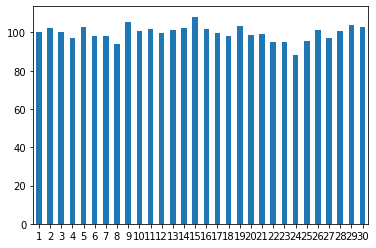

In [18]:
final_balances = pd.to_numeric(balances.iloc[-1, :])

profits = final_balances - 100000 # substract initial money

profits.rebase().plot.bar(x='Lag Time', y='Final Balance', rot=0)

profits_sorted = profits.sort_values(ascending=False) # sort the profits as descending
profits_sorted

### Balance History - Most Profited

#### Lag Time 15 - Profit 13420$

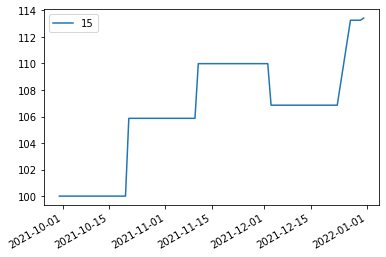

In [19]:
# Lag_time = 15
ax1 = balances.iloc[:, 14:15].rebase().plot()

#### Lag Time 9 - Profit 13059$

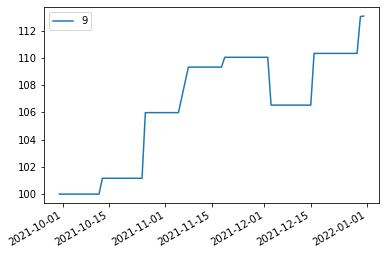

In [20]:
# Lag_time = 9
ax1 = balances.iloc[:, 8:9].rebase().plot()

#### Lag Time 29 - Profit 12878$

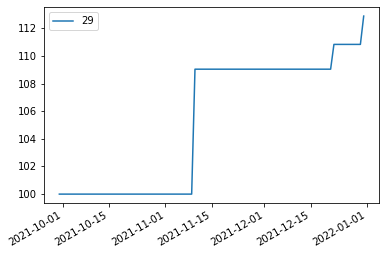

In [21]:
# Lag_time = 29
ax1 = balances.iloc[:, 28:29].rebase().plot()

### Balance History - Common Lag Times

#### Lag Time 1 (Daily Trading) - Profit 12403$

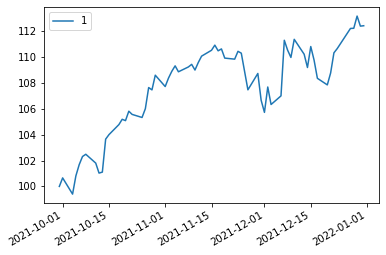

In [22]:
# Lag_time = 1
ax1 = balances.iloc[:, 0:1].rebase().plot()

#### Lag Time 5 (Weekly Trading) - Profit 12774$

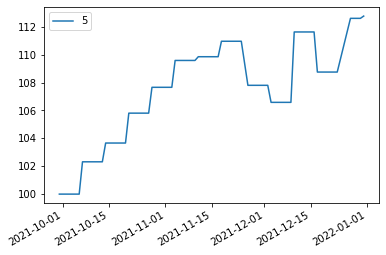

In [23]:
# Lag_time = 5
ax1 = balances.iloc[:, 4:5].rebase().plot()

#### Lag Time 20 (Monthly Trading) - Profit 12255$

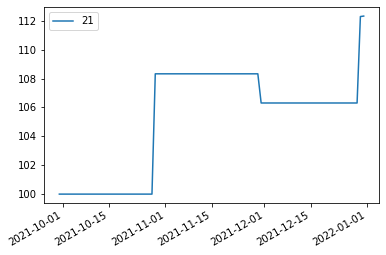

In [24]:
# Lag_time = 20 # Assuming 20 worksday in a month
ax1 = balances.iloc[:, 20:21].rebase().plot()

## Conclusion

In conclusion, this project implements a Modern Portfolio Theory with Time Series Forecasting. History dataset which contains stock prices between 2021-01-01 and 2021-09-30, is used as the training data. Along with the simulation, future prices are predicted with ARIMA Time Series Forecasting method and investment is optimized with the Modern Portfolio Theory. Given a lag time, forecasted values are replaced with the real stock prices so that Time Series Forecasting is performed under the latest known stock prices. 30 simulations are performed to evaluate the project performance with lag time varying 1 to 30. The most profited lag time is 15 and it profits 13420$. 

***calculate_weights*** function is called below with the verbose parameter being True. This displays the Portfolio performance according to the history data that contains stock prices between 2021-01-01 and 2021-09-30

In [25]:
_ = calculate_weights(history, verbose=True)

Expected annual return: 65.6%
Annual volatility: 15.0%
Sharpe Ratio: 4.24
(0.6560549410998375, 0.15014515884013774, 4.236266730231753)


## Annual Projection

In the beginning of the simulation (2021-09-30), the expected annual return is calculated by ***65.6%***

In the end of the simulation, the project profits ***13.42%*** in 3 months period

Assuming that project performs the same profit rate for future, we can calculate the expected annual rate of the project approximately.

***Profit rate of 3 months trading***: 1.1342018

***2021-10-01***: 100000.00$

***2022-01-01***: 113420.18$

***2022-04-01***: 128641.37$

***2022-07-01***: 145905.28$

***2022-10-01***: 165486.03$

According to the annual projection, the project profits ***65.5%*** in a year which is very close to the expected annual return


Profit rate of 3 months trading: 1.1342018
2021-10-01 - 100000.00
2022-01-01 - 113420.18
2022-04-01 - 128641.37
2022-07-01 - 145905.28
2022-10-01 - 165486.03


<AxesSubplot:>

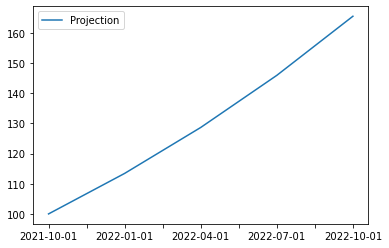

In [30]:
profit_rate_3_months = final_balances.max() / initial_balance
print(f'Profit rate of 3 months trading: {profit_rate_3_months}')
expected_annual_balance = initial_balance
expected_annual_balance_history = []
quarter_dates = ['2021-10-01', '2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01']
for quarter in quarter_dates:
    print(f'{quarter} - {expected_annual_balance:.2f}')
    expected_annual_balance_history.append(expected_annual_balance)
    expected_annual_balance *= profit_rate_3_months
    
pd.DataFrame(expected_annual_balance_history, index=quarter_dates, columns=['Projection']).rebase().plot() 

## References

<ol>
  <li><a>https://github.com/huseinzol05/Stock-Prediction-Models</a></li>
  <li><a>https://github.com/Poseyy/MarketAnalysis</a></li>
  <li><a>https://www.researchgate.net/publication/337629816_Machine_Trading_by_Time_Series_Models_and_Portfolio_Optimization</a></li>
  <li><a>https://towardsdatascience.com/optimizing-portfolios-with-modern-portfolio-theory-using-python-60ce9a597808</a></li>
  <li><a>https://pythonforfinance.net/2017/01/21/investment-portfolio-optimisation-with-python/</a></li>
  <li><a>https://machinelearningmastery.com/time-series-forecasting/</a></li>
  <li><a>https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70</a></li>
  <li><a>https://mattsosna.com/ARIMA-deep-dive/</a></li>
  <li><a>https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/</a></li>
</ol>
